In [1]:
import neurokit2 as nk
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import numpy as np
import os

from neurokit2.misc import NeuroKitWarning
from neurokit2.signal.signal_rate import _signal_rate_plot
from neurokit2.ecg.ecg_peaks import _ecg_peaks_plot
from neurokit2.ecg.ecg_segment import ecg_segment

# Paths setup
raw_data_folder = '/Users/firefly/Desktop/Team_Messung/data/rawdata'
results_folder = '/Users/firefly/Desktop/Team_Messung/data/results'
os.makedirs(results_folder, exist_ok=True)

# Parameters
participants = ['sub-01', 'sub-02']
conditions1 = ['empty', 'full']
conditions2 = ['bright', 'dark']

def process_ecg_data(participant, condition1, condition2):
    """Process ECG data for a specific participant and condition"""
    
    # Load ECG data
    filename = f"{raw_data_folder}/{participant}_{condition1}-{condition2}_ecg.csv"
    print(f"\nProcessing: {filename}")
    
    # Read the CSV file
    df = pd.read_csv(filename, header=None, names=['ECG'], skiprows=1)
    ecg_data = df['ECG'].values
    
    # First, let's show different cleaning methods
    # Take a 7-second window for comparison
    window_start = 50000
    window_end = 57000
    window_data = ecg_data[window_start:window_end]
    
    # Compare different cleaning methods
    signals = pd.DataFrame({
        "ECG_Raw": window_data,
        "ECG_NeuroKit": nk.ecg_clean(window_data, sampling_rate=1000, method="neurokit"),
        "ECG_BioSPPy": nk.ecg_clean(window_data, sampling_rate=1000, method="biosppy"),
        "ECG_PanTompkins": nk.ecg_clean(window_data, sampling_rate=1000, method="pantompkins1985")
    })
    
    # Plot cleaning comparison
    plt.figure(figsize=(15, 10))
    signals.plot(subplots=True)
    plt.tight_layout()
    plt.savefig(f"{results_folder}/{participant}_{condition1}_{condition2}_cleaning_comparison.png")
    plt.close()
    
    # Process full data
    signals_full, info = nk.ecg_process(ecg_data, sampling_rate=1000)
    
    # Select a 10-second window for detailed visualization
    window_start = 160000
    window_end = 170000
    ecg_signals = signals_full[window_start:window_end]
    
    # Create detailed plot
    if "ECG_R_Peaks" in ecg_signals.columns:
        info["ECG_R_Peaks"] = np.where(ecg_signals["ECG_R_Peaks"] == 1)[0]
    
    gs = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[2/3, 1/3])
    fig = plt.figure(figsize=(15, 10))
    
    # Create subplots
    ax0 = fig.add_subplot(gs[0, :-1])
    ax1 = fig.add_subplot(gs[1, :-1], sharex=ax0)
    ax2 = fig.add_subplot(gs[:, -1])
    
    # Plot ECG with peaks
    phase = None
    if "ECG_Phase_Ventricular" in ecg_signals.columns:
        phase = ecg_signals["ECG_Phase_Ventricular"].values
    
    ax0 = _ecg_peaks_plot(
        ecg_signals["ECG_Clean"].values,
        info=info,
        sampling_rate=info["sampling_rate"],
        raw=ecg_signals["ECG_Raw"].values,
        quality=ecg_signals["ECG_Quality"].values,
        phase=phase,
        ax=ax0
    )
    
    # Plot Heart Rate
    ax1 = _signal_rate_plot(
        ecg_signals["ECG_Rate"].values,
        info["ECG_R_Peaks"],
        sampling_rate=info["sampling_rate"],
        title="Heart Rate",
        ytitle="Beats per minute (bpm)",
        color="#FF5722",
        color_mean="#FF9800",
        color_points="#FFC107",
        ax=ax1
    )
    
    # Plot individual heart beats
    ax2 = ecg_segment(
        ecg_signals,
        info["ECG_R_Peaks"],
        info["sampling_rate"],
        show="return",
        ax=ax2
    )
    
    # Adjust subplot positions
    ax0.set_position([0.1, 0.6, 0.6, 0.35])
    ax1.set_position([0.1, 0.1, 0.6, 0.35])
    ax2.set_position([0.75, 0.1, 0.2, 0.85])
    
    # Add title
    plt.suptitle(f"ECG Analysis - {participant} ({condition1}_{condition2})", y=0.95)
    
    # Save figure
    plt.savefig(f"{results_folder}/{participant}_{condition1}_{condition2}_ecg_analysis.png", 
                bbox_inches='tight', dpi=300)
    plt.close()
    
    # Calculate interval-related metrics
    results = nk.ecg_intervalrelated(signals_full, sampling_rate=1000)
    
    # Add metadata
    results['Participant'] = participant
    results['Condition'] = f"{condition1}_{condition2}"
    
    return results

# Process all participants and conditions
all_results = []

for participant in participants:
    for cond1 in conditions1:
        for cond2 in conditions2:
            try:
                results = process_ecg_data(participant, cond1, cond2)
                all_results.append(results)
                print(f"Processed {participant} - {cond1}_{cond2}")
            except Exception as e:
                print(f"Error processing {participant} - {cond1}_{cond2}: {str(e)}")
                continue

# Combine all results
final_results = pd.concat(all_results, ignore_index=True)

# Save combined results
output_filename = f"{results_folder}/tutorial_ecg_detailed_results.csv"
final_results.to_csv(output_filename, index=False)
print(f"\nSaved detailed results to: {output_filename}")


Processing: /Users/firefly/Desktop/Team_Messung/data/rawdata/sub-01_empty-bright_ecg.csv
Processed sub-01 - empty_bright

Processing: /Users/firefly/Desktop/Team_Messung/data/rawdata/sub-01_empty-dark_ecg.csv
Processed sub-01 - empty_dark

Processing: /Users/firefly/Desktop/Team_Messung/data/rawdata/sub-01_full-bright_ecg.csv
Processed sub-01 - full_bright

Processing: /Users/firefly/Desktop/Team_Messung/data/rawdata/sub-01_full-dark_ecg.csv
Processed sub-01 - full_dark

Processing: /Users/firefly/Desktop/Team_Messung/data/rawdata/sub-02_empty-bright_ecg.csv
Processed sub-02 - empty_bright

Processing: /Users/firefly/Desktop/Team_Messung/data/rawdata/sub-02_empty-dark_ecg.csv
Processed sub-02 - empty_dark

Processing: /Users/firefly/Desktop/Team_Messung/data/rawdata/sub-02_full-bright_ecg.csv
Processed sub-02 - full_bright

Processing: /Users/firefly/Desktop/Team_Messung/data/rawdata/sub-02_full-dark_ecg.csv
Processed sub-02 - full_dark

Saved detailed results to: /Users/firefly/Deskt

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [4]:
import os
import pandas as pd
import numpy as np

# Paths to folders
results_folder = '/Users/firefly/Desktop/Team_Messung/data/results'

# Load the detailed results
filename = f"{results_folder}/tutorial_ecg_detailed_results.csv"
results = pd.read_csv(filename)

# Print column names
print("Columns in the dataset:")
print(results.columns.tolist())

# Print first few rows with their data types
print("\nData types of columns:")
print(results.dtypes)

# Print sample of first few rows
print("\nFirst few rows of data:")
print(results.head())

# Let's look at a specific row in detail
print("\nDetailed view of first row:")
for column in results.columns:
    print(f"\n{column}:")
    print(f"Value: {results[column].iloc[0]}")
    print(f"Type: {type(results[column].iloc[0])}")

Columns in the dataset:
['ECG_Rate_Mean', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2', 'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF', 'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2', 'HRV_S', 'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_PIP', 'HRV_IALS', 'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_SI', 'HRV_AI', 'HRV_PI', 'HRV_C1d', 'HRV_C1a', 'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d', 'HRV_C2a', 'HRV_SD2d', 'HRV_SD2a', 'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd', 'HRV_SDNNa', 'HRV_DFA_alpha1', 'HRV_MFDFA_alpha1_Width', 'HRV_MFDFA_alpha1_Peak', 'HRV_MFDFA_alpha1_Mean', 'HRV_MFDFA_alpha1_Max', 'HRV_MFDFA_alpha1_Delta', 'HRV_MFDFA_alpha1_Asymmetry', 'HRV_MFDFA_alpha1_Fluctuation',


HRV_SDNN by condition:
Empty-Bright: 57.659 ± 21.363
Empty-Dark: 47.309 ± 0.254
Full-Bright: 67.815 ± 17.224
Full-Dark: 73.575 ± 18.411


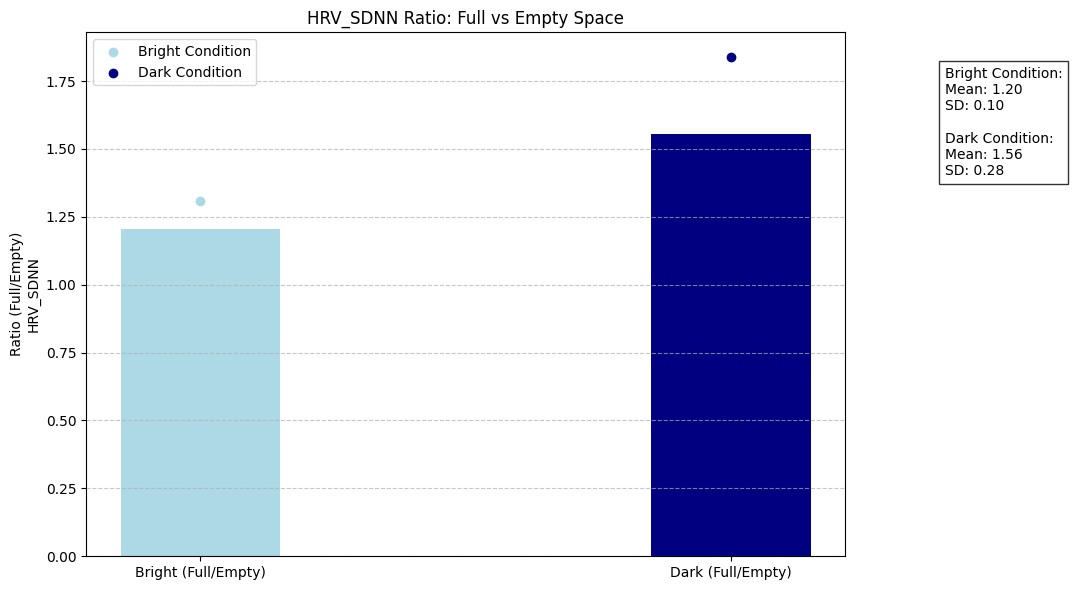


HRV_RMSSD by condition:
Empty-Bright: 35.319 ± 3.241
Empty-Dark: 39.419 ± 11.119
Full-Bright: 50.801 ± 13.260
Full-Dark: 35.156 ± 8.860


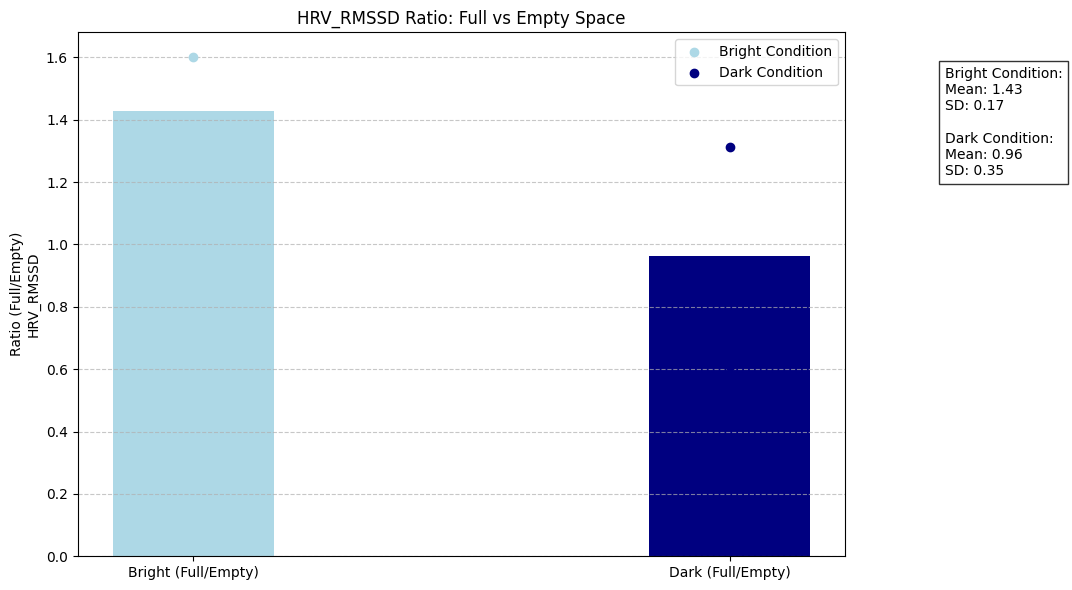


HRV_pNN50 by condition:
Empty-Bright: 9.442 ± 0.713
Empty-Dark: 9.243 ± 4.013
Full-Bright: 19.368 ± 0.575
Full-Dark: 14.455 ± 7.841


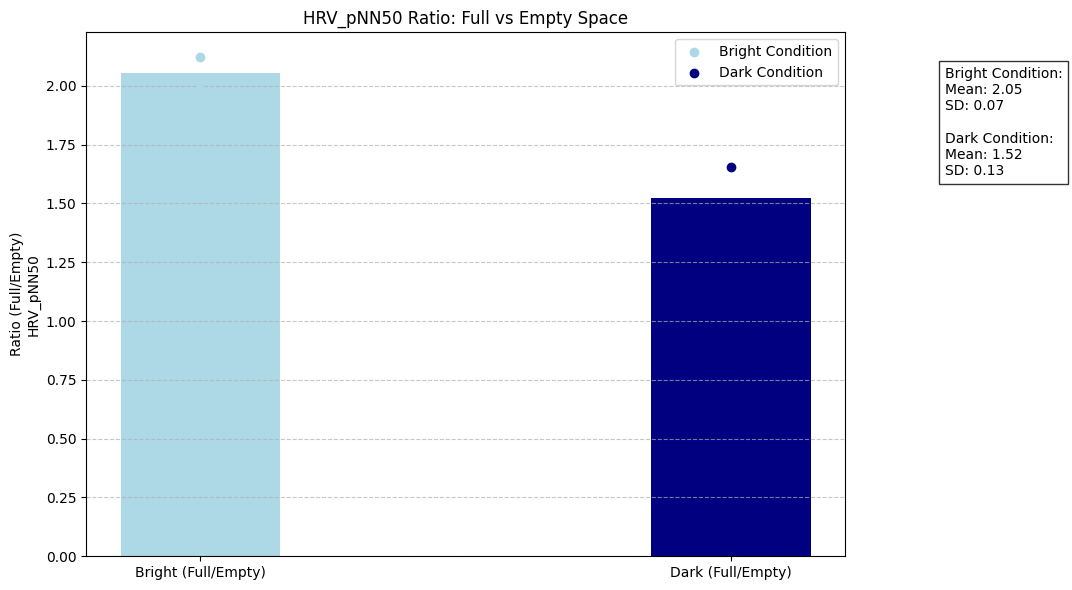


HRV_LF by condition:
Empty-Bright: 0.028 ± 0.003
Empty-Dark: 0.010 ± 0.001
Full-Bright: 0.015 ± 0.006
Full-Dark: 0.012 ± 0.008


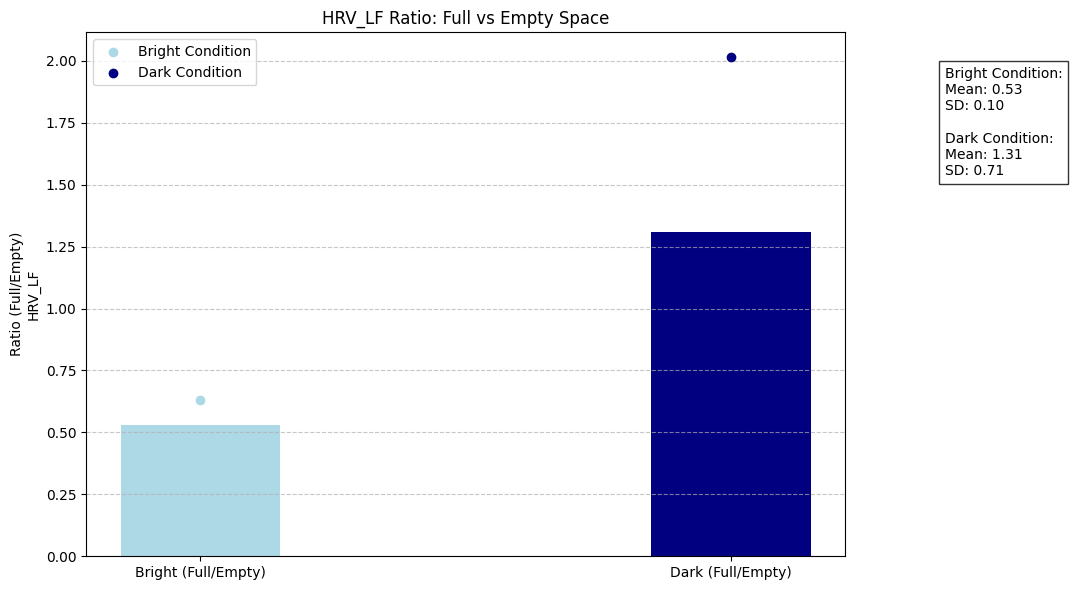


HRV_HF by condition:
Empty-Bright: 0.006 ± 0.001
Empty-Dark: 0.007 ± 0.004
Full-Bright: 0.008 ± 0.002
Full-Dark: 0.004 ± 0.002


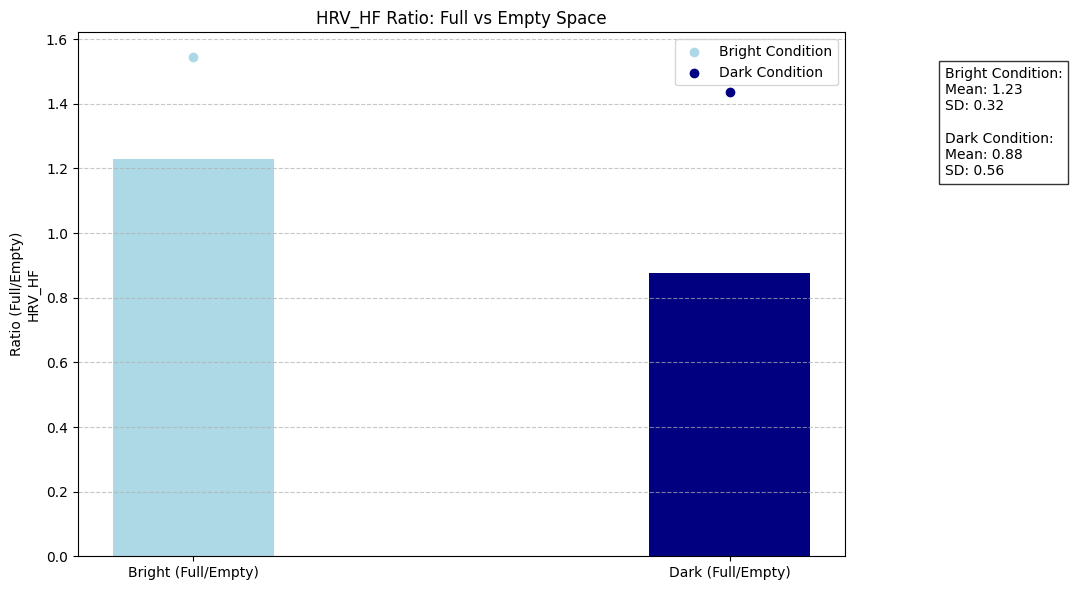


HRV_LFHF by condition:
Empty-Bright: 4.374 ± 0.197
Empty-Dark: 1.647 ± 0.768
Full-Bright: 2.087 ± 1.191
Full-Dark: 2.590 ± 0.680


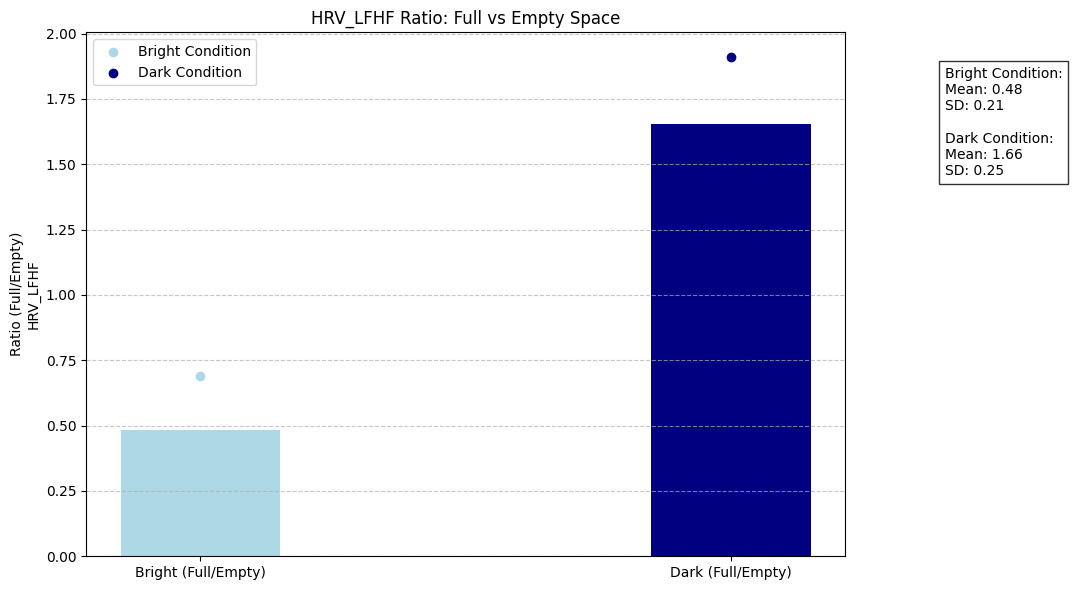


Correlation between metrics:
           HRV_SDNN  HRV_RMSSD  HRV_pNN50    HRV_LF    HRV_HF  HRV_LFHF
HRV_SDNN   1.000000   0.460473   0.573001 -0.051179 -0.025173  0.018108
HRV_RMSSD  0.460473   1.000000   0.446969 -0.151330  0.787326 -0.497537
HRV_pNN50  0.573001   0.446969   1.000000 -0.004013  0.047948 -0.064226
HRV_LF    -0.051179  -0.151330  -0.004013  1.000000  0.166570  0.878298
HRV_HF    -0.025173   0.787326   0.047948  0.166570  1.000000 -0.307027
HRV_LFHF   0.018108  -0.497537  -0.064226  0.878298 -0.307027  1.000000


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def clean_metric(value):
    """Clean metric values by removing brackets and converting to float"""
    if isinstance(value, str):
        # Remove brackets and convert to float
        cleaned = value.replace('[', '').replace(']', '')
        try:
            return float(cleaned)
        except ValueError:
            return np.nan
    return value

# Paths to folders
results_folder = '/Users/firefly/Desktop/Team_Messung/data/results'

# Load the detailed results
filename = f"{results_folder}/tutorial_ecg_detailed_results.csv"
results = pd.read_csv(filename)

# Select key HRV metrics for analysis
key_metrics = [
    'HRV_SDNN',      # Standard deviation of NN intervals
    'HRV_RMSSD',     # Root mean square of successive differences
    'HRV_pNN50',     # Proportion of NN50 divided by total number of NNs
    'HRV_LF',        # Low Frequency power
    'HRV_HF',        # High Frequency power
    'HRV_LFHF'       # LF/HF ratio
]

# Clean selected metrics
for metric in key_metrics:
    results[metric] = results[metric].apply(clean_metric)

# Filter conditions
empty_bright = results[results['Condition'] == 'empty_bright']
empty_dark = results[results['Condition'] == 'empty_dark']
full_bright = results[results['Condition'] == 'full_bright']
full_dark = results[results['Condition'] == 'full_dark']

# Process each metric
for metric in key_metrics:
    print(f"\n{metric} by condition:")
    print(f"Empty-Bright: {empty_bright[metric].mean():.3f} ± {empty_bright[metric].std():.3f}")
    print(f"Empty-Dark: {empty_dark[metric].mean():.3f} ± {empty_dark[metric].std():.3f}")
    print(f"Full-Bright: {full_bright[metric].mean():.3f} ± {full_bright[metric].std():.3f}")
    print(f"Full-Dark: {full_dark[metric].mean():.3f} ± {full_dark[metric].std():.3f}")
    
    # Calculate ratios (Full/Empty)
    ratio_bright = full_bright[metric].values / empty_bright[metric].values
    ratio_dark = full_dark[metric].values / empty_dark[metric].values
    
    # Calculate mean ratios
    avg_ratio_bright = np.nanmean(ratio_bright)
    avg_ratio_dark = np.nanmean(ratio_dark)
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    
    # Create bar plot
    conditions = ['Bright (Full/Empty)', 'Dark (Full/Empty)']
    averages = [avg_ratio_bright, avg_ratio_dark]
    bars = plt.bar(conditions, averages, color=['lightblue', 'navy'], width=0.3)
    
    # Add individual data points
    plt.scatter([0] * len(ratio_bright), ratio_bright, 
                color='lightblue', label='Bright Condition', zorder=5)
    plt.scatter([1] * len(ratio_dark), ratio_dark,
                color='navy', label='Dark Condition', zorder=5)
    
    # Customize plot
    plt.ylabel(f'Ratio (Full/Empty)\n{metric}')
    plt.title(f'{metric} Ratio: Full vs Empty Space')
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add statistical information
    plt.figtext(0.95, 0.7,
                f"Bright Condition:\nMean: {avg_ratio_bright:.2f}\nSD: {np.nanstd(ratio_bright):.2f}\n\n"
                f"Dark Condition:\nMean: {avg_ratio_dark:.2f}\nSD: {np.nanstd(ratio_dark):.2f}",
                bbox=dict(facecolor='white', alpha=0.8))
    
    # Save and show plot
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.savefig(f"{results_folder}/hrv_{metric}_ratio.png", 
                bbox_inches='tight', dpi=300)
    plt.show()

# Additional correlation analysis between metrics
print("\nCorrelation between metrics:")
correlation = results[key_metrics].corr()
print(correlation)